In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp data

# Data

> A simple API for importing and preparing data for use. Mostly manipulates numpy arrays to generate profiles and sections
> as well as plane levelling, noise removal and waviness removal. 

In [ ]:
#|hide
from nbdev.showdoc import *


In [ ]:
#note
#Generate a gausspulse for testing?

In [ ]:
#| export
import numpy as np
import imutils
import cv2 as cv
from matplotlib import pyplot as plt
import scipy.ndimage as ndimage 

We will be treating 2D arrays as rasters. Basically load any .csv, .txt or other file into a numpy  array as you would normally. Each entry should be the height data for it's respective pixel. 

Let's read an example image using the OpenCV library

In [ ]:
image = np.loadtxt('BYGS008_top_segment_500samp_10cm_interp089.txt')

Let's have a look at the image 

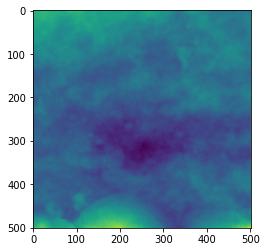

In [ ]:
plt.imshow(image)
plt.show()

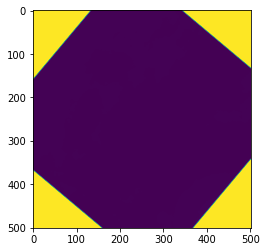

In [ ]:
image_45 = imutils.rotate(image, angle = 50)
plt.imshow(image_45)
plt.show()

In [ ]:
image.shape

(501, 501)

In [ ]:
#| export
def gen_rot_prof(array, #2D array of height values
                     deg = 180, #Number of degrees to rotate through, i.e 180 gives full 360 rotation
                     increment = 1 # indent/180 = number of evenly spaced profiles to calculate.  
                    ):
    ''' Generates an array of rotational profiles through to deg, in even increments of increment. 
    Uses OpenCV and Imutils to rotate the array around the center of the array/raster/image, extracts the middle row. 
    '''
    if deg % increment != 0:
        raise ValueError('Cannot sample evenly, deg % indent must = 0')
    profiles = np.zeros(shape = (deg//increment,array.shape[0]))
    index = 0
    center = array.shape[0]//2  #Center is returned as index to the right of center for even arrays
    for degree in range(0, deg, increment):
        rot_array = imutils.rotate(array, angle = degree)
        profiles[index, :] = rot_array[center,:]
        index += 1
    return profiles
            

In [ ]:
#| export
def level_data(array, axis = None):
    pass

In [ ]:
mean = np.array([0.0,0.0,0.0])
cov = np.array([[1.0,-0.5,0.8], [-0.5,1.1,0.0], [0.8,0.0,1.0]])
data = np.random.multivariate_normal(mean, cov, 50)

In [ ]:
data.shape

(50, 3)

In [ ]:
# export
def smooth_image(array, #Numpy array or array like
                 sigma = 1, #Standard deviation for gaussian kernel Useful for determining the wavelength of the low pass filter
                 **kwargs #Keyword arguments for modification of the gaussian_filter function
                ):
    '''
    Removes low frequency/wavelength features ('noise') by applying a gaussian filter on the image. 
    Thin wrapper of scipy.ndimage.gaussian_filter.
    '''
    return ndimage.gaussian_filter(input = array, sigma = sigma, **kwargs)

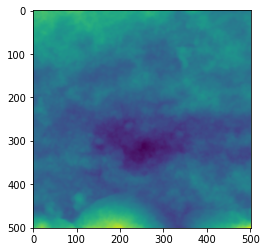

In [ ]:
plt.imshow(smooth_image(image, sigma = 1))
plt.show()

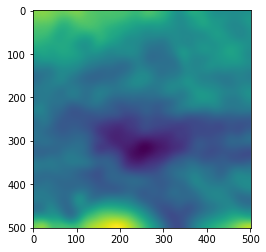

In [ ]:
plt.imshow(smooth_image(image, sigma = 10))
plt.show()

In [ ]:
#| export
def gen_sections(array #2D array (or arraylike) of height values
                ):
    pass
                 

In [ ]:
a = np.arange(5000, step=2).reshape((50,50))
a

array([[   0,    2,    4, ...,   94,   96,   98],
       [ 100,  102,  104, ...,  194,  196,  198],
       [ 200,  202,  204, ...,  294,  296,  298],
       ...,
       [4700, 4702, 4704, ..., 4794, 4796, 4798],
       [4800, 4802, 4804, ..., 4894, 4896, 4898],
       [4900, 4902, 4904, ..., 4994, 4996, 4998]])

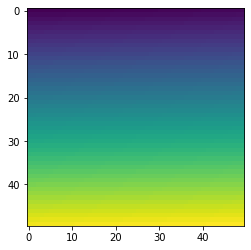

In [ ]:
plt.imshow(a,vmin = 0, vmax=5000)
plt.show()

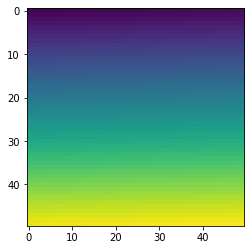

In [ ]:
b = ndimage.gaussian_filter(a, sigma=1)
plt.imshow(b, vmin=0, vmax=5000)
plt.show()

In [ ]:
b

array([[  42,   44,   46, ...,  135,  137,  139],
       [ 106,  108,  110, ...,  199,  201,  203],
       [ 200,  202,  204, ...,  293,  295,  297],
       ...,
       [4699, 4701, 4703, ..., 4792, 4794, 4796],
       [4793, 4795, 4797, ..., 4886, 4888, 4890],
       [4857, 4859, 4861, ..., 4950, 4952, 4954]])

In [ ]:
profiles =  gen_rot_prof(image,increment=5)

In [ ]:
profiles.shape

(36, 501)

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()